In [ ]:
!unzip /content/Dataset_Final.zip

Archive:  /content/Dataset_Final.zip
replace Dataset_Final/Fashion/test/Defect_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_score, recall_score,
    f1_score, accuracy_score
)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 30
LR = 1e-3

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std =[0.5, 0.5, 0.5]
    )
])

In [ ]:
class UnsupervisedImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.images = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
TRAIN_DIR = "/content/Dataset_Final/Fashion/train"
VAL_DIR   = "/content/Dataset_Final/Fashion/valid"
TEST_DIR  = "/content/Dataset_Final/Fashion/test"

In [ ]:
train_dataset = UnsupervisedImageDataset(TRAIN_DIR, transform)
val_dataset   = UnsupervisedImageDataset(VAL_DIR, transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Jumlah data train:", len(train_dataset))

Jumlah data train: 1093


In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
class VanillaAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
model = VanillaAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs = imgs.to(DEVICE)

        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for imgs in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs = imgs.to(DEVICE)
            recon = model(imgs)
            loss = criterion(recon, imgs)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {avg_train_loss:.6f} | "
        f"Val Loss: {avg_val_loss:.6f}"
    )

Epoch 1/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch [1/30] Train Loss: 0.126847 | Val Loss: 0.035602


Epoch 2/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch [2/30] Train Loss: 0.027690 | Val Loss: 0.024956


Epoch 3/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


Epoch [3/30] Train Loss: 0.023126 | Val Loss: 0.021994


Epoch 4/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch [4/30] Train Loss: 0.019239 | Val Loss: 0.017871


Epoch 5/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch [5/30] Train Loss: 0.017136 | Val Loss: 0.017380


Epoch 6/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Epoch [6/30] Train Loss: 0.014734 | Val Loss: 0.013585


Epoch 7/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch [7/30] Train Loss: 0.013064 | Val Loss: 0.012401


Epoch 8/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch [8/30] Train Loss: 0.011717 | Val Loss: 0.011324


Epoch 9/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [9/30] Train Loss: 0.010431 | Val Loss: 0.010829


Epoch 10/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch [10/30] Train Loss: 0.009892 | Val Loss: 0.009623


Epoch 11/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Epoch [11/30] Train Loss: 0.009792 | Val Loss: 0.009817


Epoch 12/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Epoch [12/30] Train Loss: 0.009173 | Val Loss: 0.008948


Epoch 13/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch [13/30] Train Loss: 0.009141 | Val Loss: 0.009100


Epoch 14/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [14/30] Train Loss: 0.008852 | Val Loss: 0.008665


Epoch 15/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch [15/30] Train Loss: 0.008532 | Val Loss: 0.008415


Epoch 16/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


Epoch [16/30] Train Loss: 0.008291 | Val Loss: 0.008278


Epoch 17/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch [17/30] Train Loss: 0.008377 | Val Loss: 0.009608


Epoch 18/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Epoch [18/30] Train Loss: 0.008659 | Val Loss: 0.008528


Epoch 19/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch [19/30] Train Loss: 0.008368 | Val Loss: 0.007834


Epoch 20/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Epoch [20/30] Train Loss: 0.008135 | Val Loss: 0.007838


Epoch 21/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


Epoch [21/30] Train Loss: 0.008010 | Val Loss: 0.007369


Epoch 22/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch [22/30] Train Loss: 0.007339 | Val Loss: 0.007287


Epoch 23/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch [23/30] Train Loss: 0.007649 | Val Loss: 0.007682


Epoch 24/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Epoch [24/30] Train Loss: 0.007583 | Val Loss: 0.007411


Epoch 25/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Epoch [25/30] Train Loss: 0.008097 | Val Loss: 0.007541


Epoch 26/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


Epoch [26/30] Train Loss: 0.007277 | Val Loss: 0.007502


Epoch 27/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch [27/30] Train Loss: 0.007339 | Val Loss: 0.006882


Epoch 28/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Epoch [28/30] Train Loss: 0.007554 | Val Loss: 0.006822


Epoch 29/30 [Val]: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch [29/30] Train Loss: 0.006763 | Val Loss: 0.006894


Epoch 30/30 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]

Epoch [30/30] Train Loss: 0.006696 | Val Loss: 0.006848


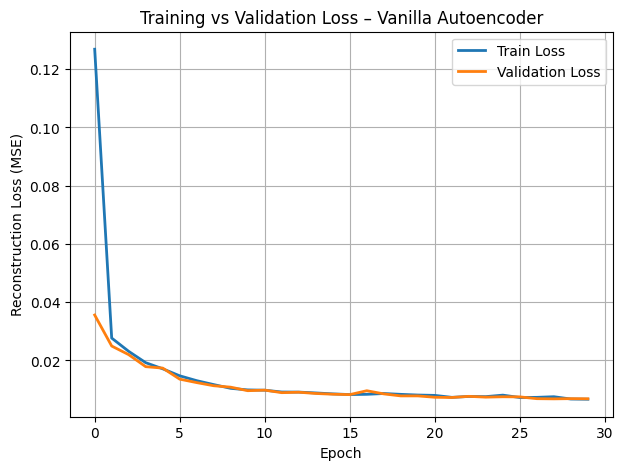

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Training vs Validation Loss – Vanilla Autoencoder")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def autoencoder_predict(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        recon = model(img)
        score = torch.mean((recon - img) ** 2).item()

    return score

In [ ]:
normal_scores = []
for img_path in val_dataset.images[:50]:
    score = autoencoder_predict(img_path)
    normal_scores.append(score)

THRESHOLD = np.mean(normal_scores) + 1.5 * np.std(normal_scores)
print("Threshold:", THRESHOLD)

Threshold: 0.01481093425339788


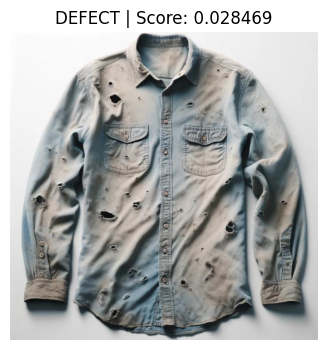

In [ ]:
img_path = "/content/Dataset_Final/Fashion/test/Defect_1.jpg"

score = autoencoder_predict(img_path)
label = "DEFECT" if score > THRESHOLD else "NORMAL"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"{label} | Score: {score:.6f}")
plt.axis("off")
plt.show()

In [ ]:
def get_label_from_name(filename):
    name = filename.lower()
    if "defect" in name:
        return 1
    elif "normal" in name:
        return 0
    else:
        raise ValueError(f"Label not found: {filename}")

In [ ]:
y_true = []
y_scores = []

for fname in tqdm(os.listdir(TEST_DIR)):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(TEST_DIR, fname)
    score = autoencoder_predict(img_path)
    label = get_label_from_name(fname)

    y_scores.append(score)
    y_true.append(label)

y_true = np.array(y_true)
y_scores = np.array(y_scores)

100%|██████████| 218/218 [00:09<00:00, 22.91it/s]


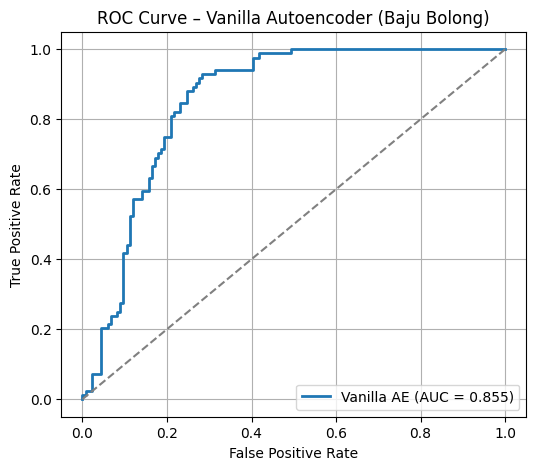

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Vanilla AE (AUC = {auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Vanilla Autoencoder (Baju Bolong)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def find_best_threshold(y_true, scores, n_steps=200):
    thresholds = np.linspace(scores.min(), scores.max(), n_steps)
    best_f1 = 0
    best_t = thresholds[0]

    for t in thresholds:
        y_pred = (scores >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

In [ ]:
THRESHOLD = find_best_threshold(y_true, y_scores)
y_pred = (y_scores >= THRESHOLD).astype(int)

print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1-score :", f1_score(y_true, y_pred))
print("Accuracy :", accuracy_score(y_true, y_pred))

Precision: 0.6818181818181818
Recall   : 0.8928571428571429
F1-score : 0.7731958762886598
Accuracy : 0.7981651376146789
